> Author Antoine CAILLON

In [2]:
import torch
from torch.utils import data
import torch.nn as nn
from glob import glob
import matplotlib.pyplot as plt
import librosa as li
import numpy as np
from IPython.display import Audio

In [2]:
class GuitarChord(data.Dataset):
    def __init__(self, files, process):
        self.liste = glob(files)
        print("Preprocessing stuff... ", end="")
        if process:
            for elm in self.liste:
                [x,fs] = li.load(elm, sr=22050)
                x = self.pad(x,34560)
                assert(len(x)==34560)
                mel = li.filters.mel(fs,2048,500)
                S = torch.from_numpy(mel.dot(abs(li.stft(x,n_fft=2048,win_length=2048, hop_length=256, center=False)))).float()
                S = S/torch.max(S)
                torch.save(S,elm.replace(".wav",".pt"))
        
        print("Done!")
    def __getitem__(self,i):
        return torch.load(self.liste[i].replace(".wav",".pt"))
    
    def __len__(self):
        return len(self.liste)
    
    def pad(self,x,n):
        m = len(x)
        if m<n:
            return np.concatenate([x,np.zeros(n-m)])
        else:
            return x[:n]
            
class WAE(nn.Module):
    def __init__(self):
        super(WAE,self).__init__()
        size = [1, 16, 32, 64, 128, 256]
        zdim = 32
        
        self.act = nn.LeakyReLU()
        
        self.enc1 = nn.Conv2d(size[0],size[1],stride=2, kernel_size=5, padding=2)
        self.enc2 = nn.Conv2d(size[1],size[2],stride=2, kernel_size=5, padding=2)
        self.enc3 = nn.Conv2d(size[2],size[3],stride=2, kernel_size=5, padding=2)
        self.enc4 = nn.Conv2d(size[3],size[4],stride=2, kernel_size=5, padding=2)
        self.enc5 = nn.Conv2d(size[4],size[5],stride=2, kernel_size=5, padding=2)
        
        self.lin1 = nn.Linear(256*16*4, 1024)
        self.lin2 = nn.Linear(1024, 256)
        self.lin3 = nn.Linear(256, zdim)
        
        self.decf = nn.Conv2d(1,1,stride=1, kernel_size=3, padding=1)
        self.dec0 = nn.ConvTranspose2d(size[0],size[0],stride=2, kernel_size=5, padding=2)
        self.dec1 = nn.ConvTranspose2d(size[1],size[0],stride=2, kernel_size=5, padding=2)
        self.dec2 = nn.ConvTranspose2d(size[2],size[1],stride=2, kernel_size=5, padding=2)
        self.dec3 = nn.ConvTranspose2d(size[3],size[2],stride=2, kernel_size=5, padding=2)
        self.dec4 = nn.ConvTranspose2d(size[4],size[3],stride=2, kernel_size=5, padding=2)
        self.dec5 = nn.ConvTranspose2d(size[5],size[4],stride=2, kernel_size=5, padding=2)
        
        self.dlin1 = nn.Linear(1024,256*16*4)
        self.dlin2 = nn.Linear(256,1024)
        self.dlin3 = nn.Linear(zdim,256)
        
        self.f1   = nn.Sequential(self.enc1,
                                nn.BatchNorm2d(num_features=size[1]),self.act, 
                                self.enc2,
                                nn.BatchNorm2d(num_features=size[2]),self.act, 
                                self.enc3,
                                nn.BatchNorm2d(num_features=size[3]),self.act, 
                                self.enc4,
                                nn.BatchNorm2d(num_features=size[4]),self.act, 
                                self.enc5,
                                nn.BatchNorm2d(num_features=size[5]),self.act)
        
        self.f2   = nn.Sequential(self.lin1,
                                 nn.BatchNorm1d(num_features=1024),self.act,  
                                 self.lin2,
                                 nn.BatchNorm1d(num_features=256),self.act,
                                 self.lin3)
        
        self.f3   = nn.Sequential(self.dlin3,
                                  nn.BatchNorm1d(num_features=256), self.act,
                                  self.dlin2,
                                  nn.BatchNorm1d(num_features=1024), self.act,
                                  self.dlin1,
                                  nn.BatchNorm1d(num_features=256*16*4), self.act)
        
        self.f4   = nn.Sequential(self.dec5,
                                 nn.BatchNorm2d(num_features=size[4]), self.act,
                                 self.dec4,
                                 nn.BatchNorm2d(num_features=size[3]), self.act,
                                 self.dec3,
                                 nn.BatchNorm2d(num_features=size[2]), self.act,
                                 self.dec2,
                                 nn.BatchNorm2d(num_features=size[1]), self.act,
                                 self.dec1,
                                 nn.BatchNorm2d(num_features=size[0]), self.act,
                                 self.dec0, nn.Sigmoid())
                                  
        
        
        
    def flatten(self, inp):
        dim = 1
        for i,elm in enumerate(inp.size()):
            if i!=0:
                dim *= elm
        return inp.view(-1,dim)
    
    def encode(self, inp):
        inp = inp.unsqueeze(1)
        inp = self.f1(inp)
        #print(inp.size())
        inp = self.flatten(inp)
        inp = self.f2(inp)
        return inp
    
    def decode(self, inp):
        #print(inp.size())
        inp = self.f3(inp)
        inp = inp.view(-1, 256, 16, 4)
        inp = self.f4(inp)
        inp = nn.functional.interpolate(inp, size=(500,128))
        inp = self.decf(inp)
        inp = torch.sigmoid(inp)
        return inp.squeeze(1)
        
    
    def forward(self,inp):
        return self.decode(self.encode(inp))  
        
        

In [3]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [4]:
GC = GuitarChord(files="ukulele_sample_pack/*.wav", process=False)
GCloader = data.DataLoader(GC, batch_size=8, shuffle=True, drop_last=True)


Preprocessing stuff... Done!


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)
torch.cuda.empty_cache()

#model = WAE().to(device)
model = torch.load("model_10000_epoch.pt")

cuda:0


/home/antoine/lap/lib/python3.6/site-packages/torch/serialization.py:400: UserWarning: Couldn't retrieve source code for container of type WAE. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [11]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
epoch = 1000
loss = torch.nn.modules.BCELoss()
for e in range(epoch):
    for idx, minibatch in enumerate(GCloader):
    
        minibatch = minibatch.to(device)
    
        optimizer.zero_grad()
        
        z = model.encode(minibatch)
        
        rec = model.decode(z)
        
        error = loss(rec,minibatch) + compute_mmd(z,torch.randn_like(z))
    
        error.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        
    if e%(epoch//10)==0:
        print("EPOCH %d, ERROR %f" % (e,error))
    
    if (e+1)%(epoch//3)==0:
        lr /= 2.
        optimizer = torch.optim.Adam(model.parameters(),lr=lr)

EPOCH 0, ERROR 0.488422
EPOCH 100, ERROR 0.148270
EPOCH 200, ERROR 0.058542
EPOCH 300, ERROR 0.039038
EPOCH 400, ERROR 0.024983
EPOCH 500, ERROR 0.016648
EPOCH 600, ERROR 0.016942
EPOCH 700, ERROR 0.014217
EPOCH 800, ERROR 0.013962
EPOCH 900, ERROR 0.010656


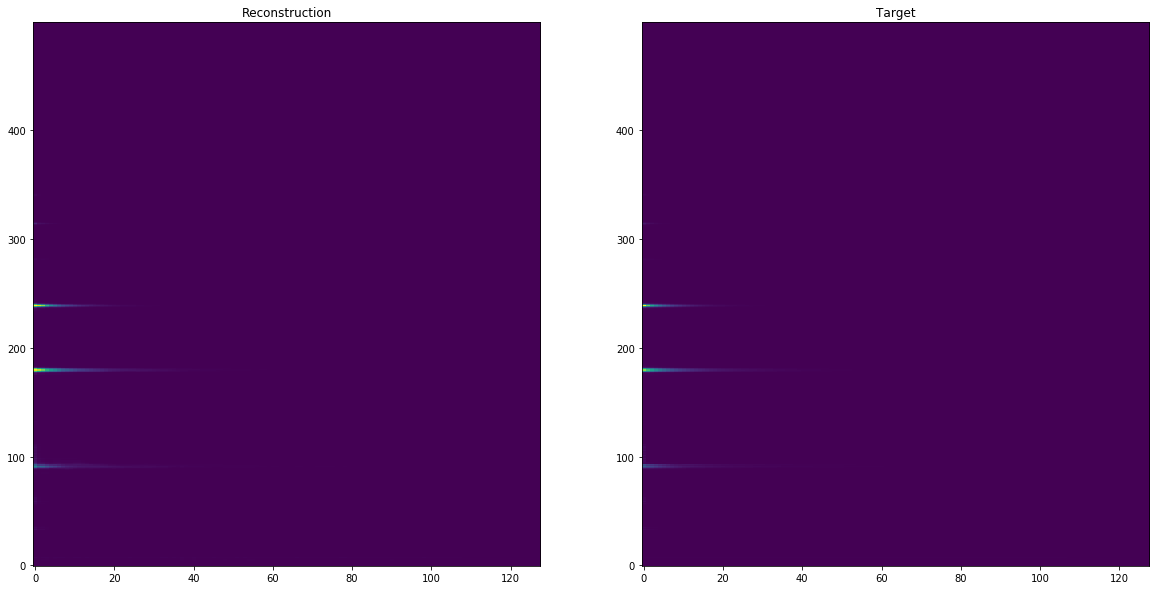

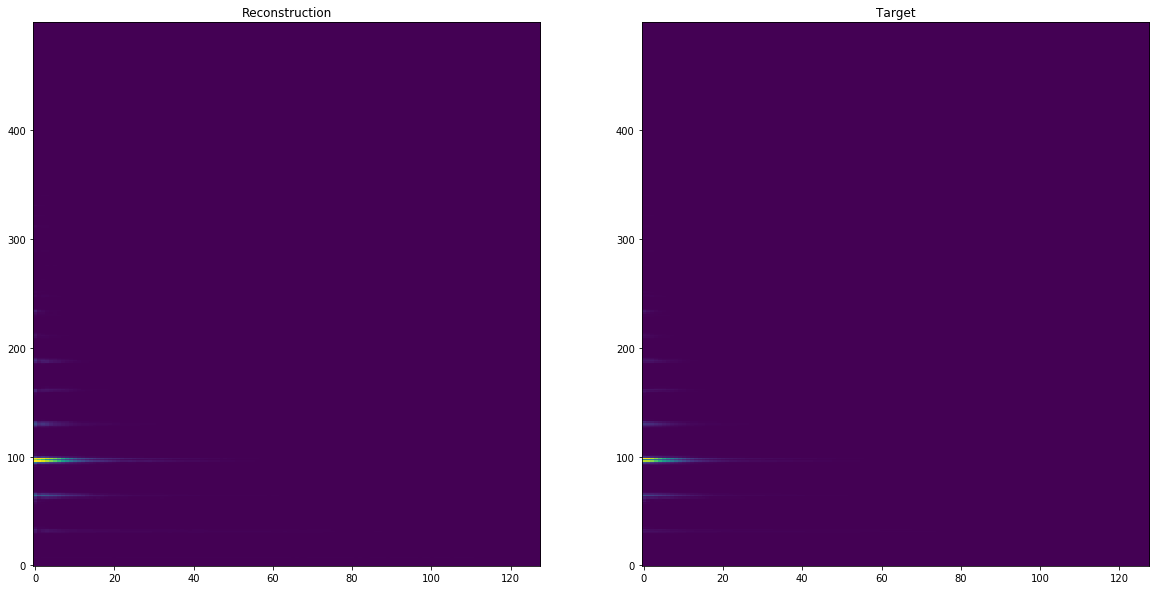

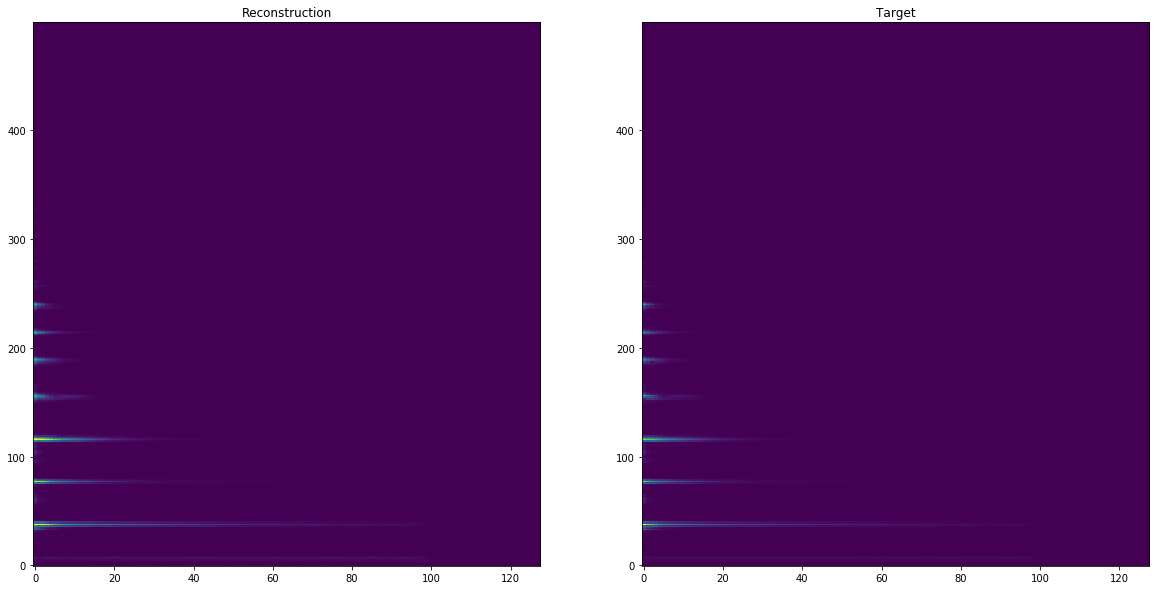

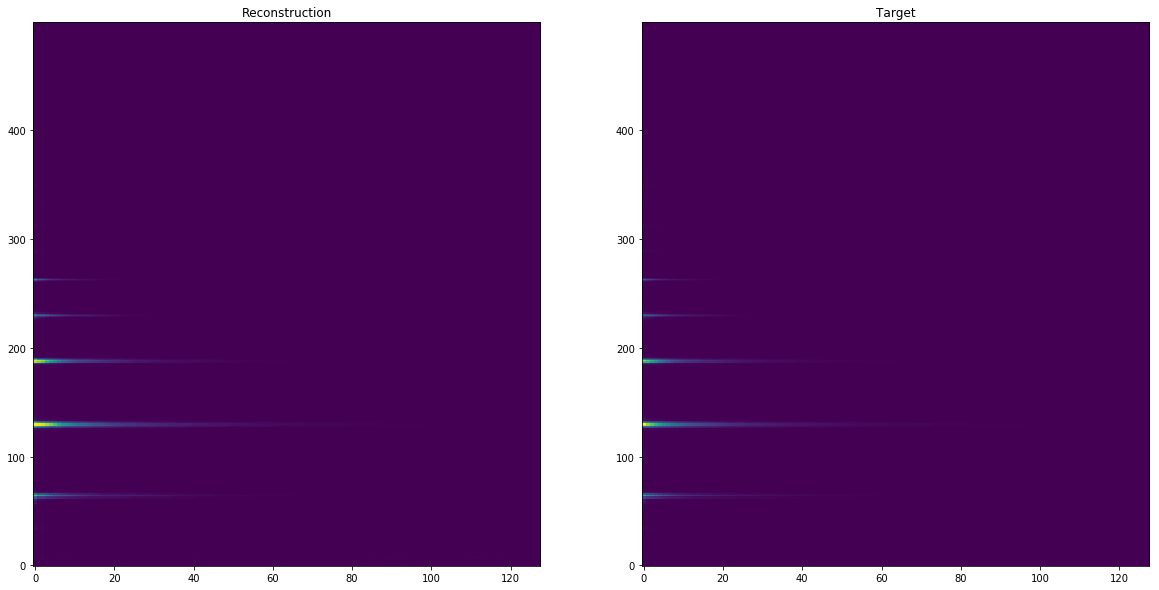

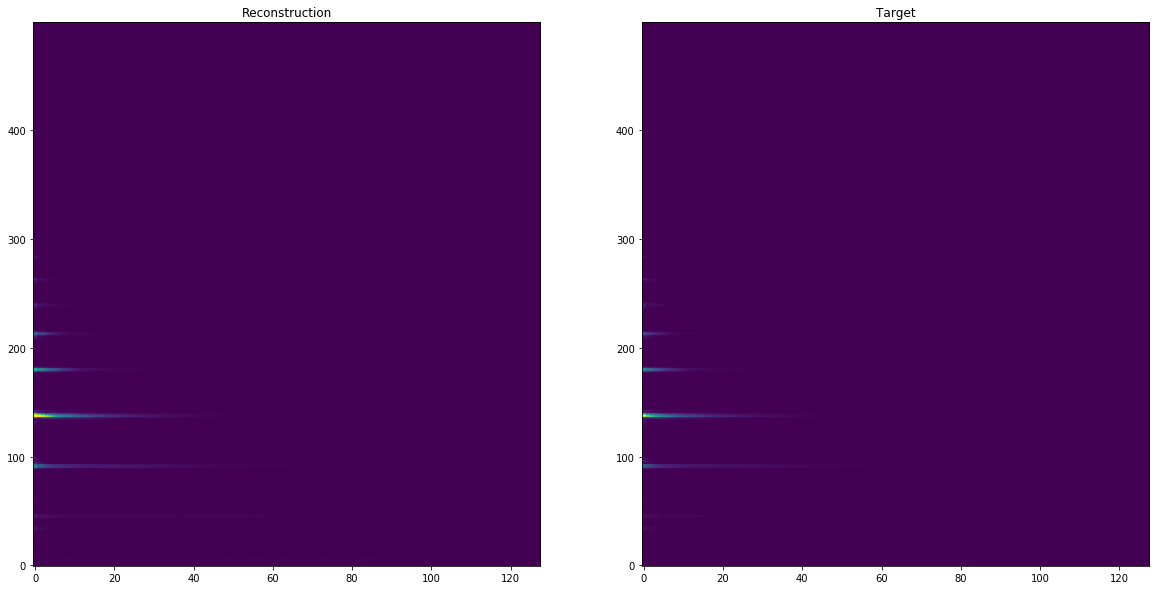

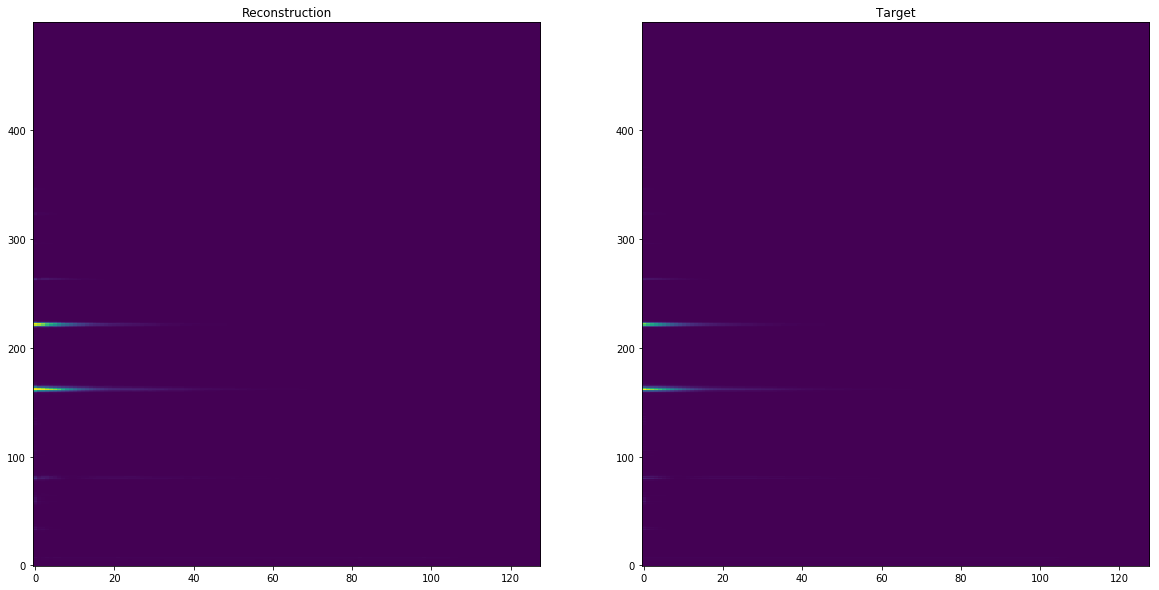

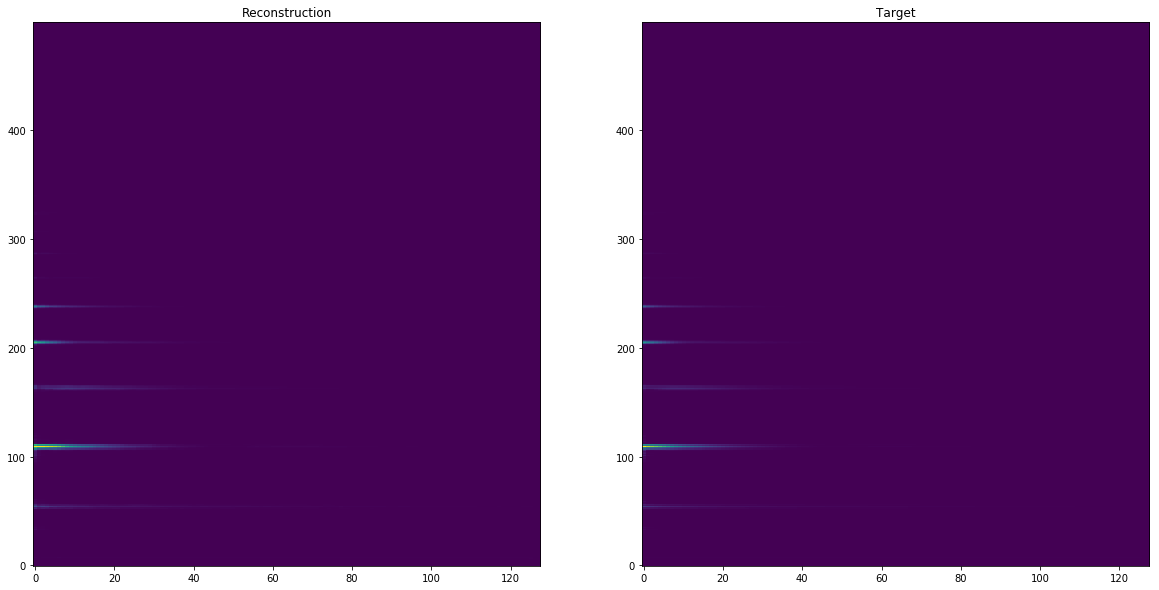

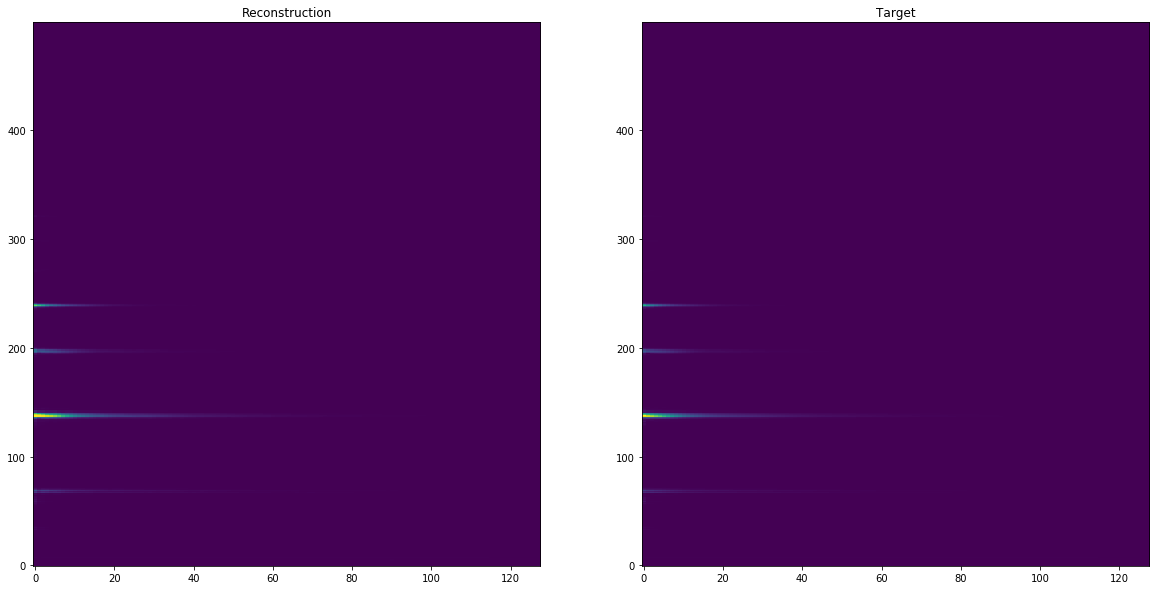

In [7]:
for idx,minibatch in enumerate(GCloader):
    minibatch = minibatch.to(device)
    break

for idx in range(8):
    with torch.no_grad():
        s = model(minibatch).squeeze(1)
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(s[idx,:,:].cpu().detach().numpy(), origin="lower", aspect="auto")
        plt.title("Reconstruction")
        plt.subplot(122)
        plt.imshow(minibatch[idx,:,:].cpu().detach().numpy(), origin="lower", aspect="auto")
        plt.title("Target")
        plt.savefig("Reconstruction.png")

In [3]:
class ModelBidon(torch.jit.ScriptModule):
    def __init__(self):
        super(ModelBidon,self).__init__()
        
    @torch.jit.script_method
    def forward(self, inp):
        x = torch.cos(inp[:,4]*2*3.14*torch.arange(34560)).view(-1,34560)
        stft = torch.stft(x, win_length=2048, hop_length=256, n_fft=2048)
        amp = torch.sqrt(stft[:,:,0]**2 + stft[:,:,1]**2)
        return x
    
MB = ModelBidon()
MB.save("modelbidon.pt")

In [4]:
MB(torch.tensor([0,0,0,0,.5]).unsqueeze(0))

tensor([[ 1.0000, -1.0000,  1.0000,  ..., -0.0551,  0.0560, -0.0570]])

In [24]:
def train(model, GCloader, epoch):
    model.train()
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    loss = torch.nn.modules.BCELoss()
    for e in range(epoch):
        for idx, minibatch in enumerate(GCloader):

            minibatch = minibatch.to(device)

            optimizer.zero_grad()

            z = model.encode(minibatch)

            rec = model.decode(z)

            error = loss(rec,minibatch) + compute_mmd(z,torch.randn_like(z))

            error.backward()
            optimizer.step()
            torch.cuda.empty_cache()

        if e%(epoch//10)==0:
            print("EPOCH %d, ERROR %f" % (e,error))

        if (e+1)%(epoch//3)==0:
            lr /= 2.
            optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [6]:
MCNN = torch.load("MCNN.pt")

In [7]:
for elm in MCNN:
    print(elm)

loss_log
epoch
state
optim


In [2]:
help(torch.stft)

Help on function stft in module torch.functional:

stft(input, n_fft, hop_length=None, win_length=None, window=None, center=True, pad_mode='reflect', normalized=False, onesided=True)
    Short-time Fourier transform (STFT).
    
    Ignoring the optional batch dimension, this method computes the following
    expression:
    
    .. math::
        X[m, \omega] = \sum_{k = 0}^{\text{win\_length}}%
                            \text{window}[k]\ \text{input}[m \times \text{hop\_length} + k]\ %
                            \exp\left(- j \frac{2 \pi \cdot \omega k}{\text{win\_length}}\right),
    
    where :math:`m` is the index of the sliding window, and :math:`\omega` is
    the frequency that :math:`0 \leq \omega < \text{n\_fft}`. When
    :attr:`onesided` is the default value ``True``,
    
    * :attr:`input` must be either a 1-D time sequence or a 2-D batch of time
      sequences.
    
    * If :attr:`hop_length` is ``None`` (default), it is treated as equal to
      ``floor(n_fft / 4

In [10]:
x = torch.cos(440*torch.linspace(0,1,34560))

In [12]:
torch.stft(x, win_length=2048, hop_length=256, n_fft=2048, center=True).size()

torch.Size([1025, 136, 2])

In [5]:
!curl --upload-file modelbidon.pt https://transfer.sh/model_bidon.pt

curl: (6) Could not resolve host: transfer.sh
